# Measurement Error Mitigation

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

## Outline

Measurement is used to extract the operation results of quantum circuits. Due to various reasons, the measurement equipment will contain noise, resulting in the errors of subsequent calculation results based on the measurement results. Therefore, it is very important to mitigate the measurement noise. This tutorial will introduce the theory of quantum measurement noise mitigation and its application on [Baidu Quantum Platform](https://quantum.baidu.com/)


## Theory
The results of quantum circuits need to be measured, and the measurement will cause errors due to problems such as instruments in practical operation.

A classical quantum algorithm framework is: **Preparation of initial state** -> **Evolution of quantum circuit** -> **Measurement** -> **Calculation of expected value**. Many famous quantum algorithms, such as quantum variational solver [1], quantum approximate optimization algorithm [2] and quantum machine learning [3, 4], are abstracted from this algorithm framework.

Experimental data [5, 6] and theoretical analysis [7] indicate, noise in a measurement device can be viewed as classical noise, that is, a noise measurement device with $n$ qubits can be modeled as an ideal measurement device with $n$ qubits to concatenate classical Markov processes, such classical Markov processes can be described by a $2^{n} \times 2^{n}$ column random matrix $R$：

$$
\begin{equation}
m = Rt,
\end{equation}
$$

'$m$' here means measurement, that is measurement value (or output). '$t$' means truth, that is truth value (or input). Both of them are  $2^n \times 1$ column vectors. Each element represents the number (or probability) of occurrences of a quantum state. $R$ represents the transition probability matrix, or calibration matrix. The stochastic nature of $R$'s column guarantees that it maps a probability distribution to a probability distribution. $R_{ij}$ represents the probability that the true value is $j$ but the measured value is $i$.

Measurement Error Mitigation (MEM) tries to correct the errors caused by measurement operation in quantum circuits by using classical statistical methods, such as least square method. Specifically, through circuits calibration, we can obtain a calibration matrix (transition probability matrix) which can help us to know what the output of each input state will be due to the measurement noise. 

The specific process is summarized as follows：

**Step 1:** Prepare standard base quantum states $\lvert{x}\rangle$ , $x\in\left\{0,1\right\}^n$ . Sometimes we use binary expressions $x\equiv x_0\cdots x_{n-1}$ , $x_i\in\left\{0,1\right\}$ .

**Step 2:** Enter $\lvert{x} \rangle$ each time, repeat the execution of noisy measuring equipment for a total of $M $times, count the number of times the output result is binary string $y$, obtaining $M_{y\vert x}$ , $y\in\left\{0,1\right\}^n$ . From definition,

 $$
 \begin{aligned}
 M = \sum_{y\in\left\{0,1\right\}^n}M_{y\vert x}
 \end{aligned}
 .\tag{1}
 $$

**Step 3:** Use data sets $\left\{M_{y\vert x}\right\}_{y}$ to calculate the elements in column $x$ of noise matrix $R$ . Use $R_{yx}$ represents the element in row $y$ and column $x$ of matrix $R$ ,

$$
\begin{aligned}
\forall y\in\left\{0,1\right\}^n,\; R_{yx} = \frac{M_{y\vert x}}{M}
\end{aligned}
.\tag{2}
$$

Equation (1) ensures that the $x$ column of $R$ constructed above satisfies the column stochastic property.

**Step 4:** Repeat the above three steps to calculate all elements of $R$ .

If the number of qubits is $n = 3$ , we can construct the following calibration matrix $R$

$$
\begin{align}
\begin{array}{ll} &
\begin{array}{ccc} \vert 000\rangle & \cdots & \vert111\rangle \end{array} \leftarrow{t, {\rm input}}
\\
R=\begin{array}{ccc}
\vert 000\rangle \\
\vdots \\
\vert 111\rangle \end{array}
&
\left[
\begin{array}{ccc}
R_{11} &\cdots & R_{18} \\
\vdots&\ddots&\vdots \\
R_{81} & \cdots & R_{88}
\end{array}
\right]
\end{array},
\end{align}
$$

to describe the statistical information of measurement noise, and this step corresponds to the **calibration** process of the quantum circuit. Obviously, the greater the total number of repetitions $ M $ in **step 2**, the more accurate the description of the noise matrix $ R $, but the greater the computational overhead. When the number of qubits $ n $ increases, the quantum measurement calibration calculation is very large. We need to prepare a total of $2^n \times M $ initial states. In addition, the above calibration method does not consider the actual situation of quantum measurement equipment, for example, there is no crosstalk between some quantum bits. When there is no crosstalk between single qubit, quantum measurement calibration can be realized efficiently (such as **tensor product calibration**).

After obtaining the calibration matrix, we can **correct** the measurement noise of the calculation results of any calculation task. Specifically, there are four methods - **Matrix inversion method**, **Least square method**, **Iterative Bayesian Unfolding (IBU) method** and **Neumann series method**. These four methods are to solve one problem:

**On the premise of knowing $m$ and $r$, how to solve $t$ of $m=Rt$**.

### Measurement calibration
#### Complete model calibration
Now let's talk about circuit calibration more specifically.

For $n$ qubits, we enumerate all states, generate a large number of corresponding circuits, perform measurements, obtain the statistical information of each input state and its corresponding output state, and finally construct a $2^n \times 2^n$ matrix, which is the calibration matrix, or transfer probability matrix. Such method is called **Complete Model Calibration**. 

It is a model that does not assume that the quantum circuit has any structure. The *"do not assume that the quantum circuit has any structure"* here corresponds to the **tensor product calibration** mentioned later. You can remember it first and understand it later. One advantage of full measurement calibration is that we can get all the statistical information about the measurement noise, and its disadvantages are also included in its advantages: it is quite resource-consuming, and this disadvantage does not mean that we need to completely deny it, because we only need to calibrate once to get all the information.


#### Tensor product calibration
In addition to complete model calibration, there is another calibration method that can characterize the measurement noise, which is **Tensor Product Calibration**.

**Tensor product calibration** assumes that there is no measured crosstalk between qubits, and the quantum circuit can be regarded as an $n$ qubit composite system. According to the fourth postulate of quantum mechanics, the state space of the composite physical system is the tensor product of the state space of the sub physical system. At this time, the noise matrix can be regarded as the tensor product of each single qubit noise matrix. The specific operation is to generate $n$ qubits $\vert 0 \cdots 0 \rangle$ and $\vert 1 \cdots 1 \rangle $ circuits, measure and count the results of output states. 

It should be noted here that we need to process the statistical results. Because there are $2^n$ possible state outputs for these two states (or these two types of input circuits), but what tensor product calibration needs is to construct a $2^n \times 2^n$ calibration matrix by calculating the tensor product of the $2 \times 2$ calibration matrix of each qubit, which means that we should first calculate the statistical results of each qubit according to the output results, that is, **calculate the edge distribution according to the joint distribution to obtain the calibration matrix of each qubit**, and then do the tensor product to obtain the $2^n \times 2^n$ calibration matrix.

The advantage of **tensor product calibration** is obvious, which greatly reduces the required computing resources. For the simultaneous measurement of $n$ qubits, we only need to prepare $2 \times M $ initial states, but it should be noted that **tensor product calibration** is based on the premise that there is no measurement crosstalk between qubits.

### Measurement correction

#### Matrix Inversion Method
After we get the calibration matrix, we can use it to correct the calculation results. From $m = Rt$, we can see that the simplest and most intuitive method to solve the probability distribution **t** of the true value is to multiply both sides left by $R^{- 1} $, then

$$
t = R^{-1}m.
$$

Although this method is very simple, it is also quite rough, because we can't guarantee $R ^{-1} $ exists. Secondly, if $R^{- 1} $ exists, the computational complexity is relatively high [8]. Finally, assuming that $R^{-1} $ exists and has been calculated, we cannot guarantee that $R^{- 1}$ is a transition probability distribution, that is, there may be negative values in $R^{-1}$. For example, for a 

$$
\begin{align}
R=\left[\begin{matrix}
 0.75 & 0.25 \\
 0.25 & 0.75
\end{matrix}\right],
\end{align}
$$

we have

$$
\begin{align}
R^{-1}=\left[\begin{matrix}
 1.5 & -0.5 \\
 -0.5 & 1.5
\end{matrix}\right],
\end{align}
$$

Based on the first disadvantage mentioned above, when we actually calculate $R^{- 1}$, we calculate its pseudo inverse [9].

#### Least Square Method

We can also use the least square method to solve this problem, because in essence, the problem of solving the probability distribution of true values can be regarded as the following optimization problem:

$$
\begin{align}
t^\ast = \operatorname*{argmin}_t&\; {\vert \vert m - Rt\vert\vert}^2, \\
         {\rm s.t.}&\; {\vert \vert t\vert\vert}_1 = {\vert \vert m\vert\vert}_1, \quad t_i\geq 0.
\end{align}
$$

This well solves the deficiency of matrix inversion method. Because of the constraints, we can ensure that the final result is a reasonable probability distribution.

#### IBU Method
We can also regard the problem of finding the true distribution as knowing the likelihood of $t$, solving the a posteriori probability of $t$, and correcting the data according to the a posteriori probability. This is a method based on Bayesian theorem, which is IBU method.

IBU method is a data processing method based on Bayesian theorem. Bayesian theorem gives the relationship between a priori probability and a posteriori probability [10],

$$
\begin{equation}
P\left(A\vert B\right) = \frac{P\left(B\vert A\right)P\left(A\right)}{P\left(B\right)},
\end{equation}
$$

- $P\left(A\vert B\right)$ is the conditional probability of event $A$ occurring given that $B$ is true, also known as the posteriori probability of $A$ given $B$.
- $P\left(A\right)$ is a priori probability of $A$, or edge probability.
- $P\left(B\vert A\right)$ is the conditional probability of event $B$ occurring given that $A$ is true, which is also called the posteriori probability of $B$ given $A$, or the likelihood of $A$ given a fixed $B$.
- $P\left(B\right)$ a priori probability of $B$.

We can more simply describe Bayesian theorem as:

$$
\begin{equation}
\text{posterior probability} = \frac{\text{likelihood $\times$ prior probability}}{\text{normalized constant}},
\end{equation}
$$

Specifically for our problem, the posteriori probability of $t$ is expressed as

$$
\begin{equation}
P\left(t\vert m\right) = \frac{P\left(m\vert t\right)P\left(t\right)}{P\left(m\right)}.
\end{equation}
$$

To start, $P\left(m\vert t\right)$ is given by calibration matrix $R$. $P\left(t\right)$ we can first give a guessed value as the initial value, and $P\left(m\right)$ is given by the calibration matrix $R$ and the guessed $t$. And then, through iteration, we can constantly modify $P\left(t\right)$ and $P\left(m\right)$ to obtain more accurate $P\left(t\vert m\right)$.

This method has not yet given how many iterations can achieve convergence in theory. According to experience, when the number of iterations reaches $10$, it can have a good convergence effect [11]. In practice, the distance between two iterations can also be used to judge whether convergence is achieved or not.

#### Neumann Series Method
The core idea of truncated Neumann series is to approximate $R^{-1}$ by series expansion.

$$
\begin{equation}
    R^{-1} = \sum_{k=0}^{\infty}\left(I-R\right)^k = \sum_{k=0}^{K}c_K\left(k\right) R^k + \mathcal{O}\left(\left(I-R\right)^{K+1}\right),
\end{equation}
$$

where $c_K\left(k\right)=\left(-1\right)^k \dbinom{K+1}{k+1}$ using binomial series expansion.

So how many orders should be expanded to ensure accuracy?

Define

$$
\begin{equation}
    K=\frac{\log\epsilon}{\log\xi}-1,
\end{equation}
$$

where $\epsilon$ is the precision we expect, $\xi$ is **noise resistance**, the mathematical expression is

$$
\begin{equation}
    \xi = 2\left(1-\min_{x\in\left\{0, 1\right\}^n}\langle x\vert R\vert x\rangle\right).
\end{equation}
$$

It describes the maximum probability of measurement noise to interfere with the measurement results. It can be proved that the resulting order $K$ can well ensure the accuracy [12].

Now that we have $R^{-1} $, we can act on the measurement result $m$ and get the correction result $t$.

## Practice

### Task description
Before the specific example display, we first have an overall grasp of the position of the two processes of measurement noise calibration and correction in the application. Through this flow chart, it is not difficult for us to understand that the process on the left is explicit from constructing the circuit of the calculation task to correcting to calculating the expected value, while the process on the right corresponds to the calibration process, which is implicit. It is hidden behind the correction process and provides a calibration matrix for the correction process. And it is worth mentioning that many quantum circuits may be constructed in one computing task. We only need to calibrate once to obtain the calibration data and construct the calibration matrix, because the calibration matrix has described the impact of measurement noise on different states, instead of constructing and running the calibration circuit every time the quantum circuit is operated.

![photo](figures/mem-steps.png "Figure 1: Flow chart of MEM")

Next, we show the measurement error mitigation through a GHZ state.
We first generate a large number of GHZ states of $2$ qubits (strictly speaking, it should be called Bell state. For convenience of description, it is unified as GHZ state in the tutorial), measure them on the $Z$-basis, obtain the statistical information of the output states, and then calculate the expectation value of observation operator

$$
\begin{equation}
O = {\vert0\rangle\langle0\vert}^{\otimes2}+{\vert1\rangle\langle1\vert}^{\otimes2}.
\end{equation}
$$

Ideally, the result should be 1, but if there is noise, the expected value will not be equal to $1$.

### Noisy results

First, we import the necessary libraries

In [1]:
import copy
import numpy as np
import functools
import matplotlib.pyplot as plt
import seaborn
import pandas
from QCompute import *

from qcompute_qep.measurement.correction import InverseCorrector, LeastSquareCorrector, IBUCorrector, NeumannCorrector
from qcompute_qep.measurement.utils import plot_histograms, dict2vector
from qcompute_qep.utils import expval_from_counts
from qcompute_qep.utils.types import get_qc_name
from qcompute_qep.utils.circuit import execute

Then, we need to obtain the token from the Quantum Leaf to use the real quantum computing machine

In [2]:
# Please login the "Quantum Leaf" platform (https://quantum-hub.baidu.com/) to get Token
Define.hubToken = "Token"

# Set the default maximal number of measurement shots
MAX_SHOTS = 8192

Then we begin to construct the quantum circuit corresponding to the GHZ state, and obtain the statistical results of the output state through the measurement in the $Z$ direction

In [3]:
qp = QEnv()
n = 2
qp.Q.createList(n)
H(qp.Q[0])
for i in range(1, n):
    CX(qp.Q[0], qp.Q[i])

MeasureZ(*qp.Q.toListPair())

Now we construct the observation operator

In [4]:
proj0 = np.array([[1, 0], [0, 0]]).astype(complex)
proj1 = np.array([[0, 0], [0, 1]]).astype(complex)
O = functools.reduce(np.kron, [proj0] * n) + functools.reduce(np.kron, [proj1] * n)

Select the quantum computer to be used for calculation. LocalBaiduSim2 is the ideal simulator, and CloudBaiduQPUQian is the real quantum machine providedy by IoPCAS

In [5]:
ideal_qc = BackendName.LocalBaiduSim2

noisy_qc = BackendName.CloudBaiduQPUQian

noisy_qc_name = get_qc_name(noisy_qc)

Obtain the execution result of the quantum computer (that is the statistical information of the output state), and use the statistical information to calculate the expected value of the observation operator $O$

In [6]:
# WARNING! We must deep copy the quantum program since `execute` will destroy the quantum program

# Ideal case.
counts_ideal = execute(qp=copy.deepcopy(qp), qc=ideal_qc, shots=MAX_SHOTS)
val_ideal = expval_from_counts(O, counts_ideal)

print("The ideal expectation value is: {}".format(val_ideal))

# Noisy case.
counts_noisy = execute(qp=copy.deepcopy(qp), qc=noisy_qc, shots=MAX_SHOTS)
val_noisy = expval_from_counts(O, counts_noisy)

print("The noisy expectation value is: {}".format(val_noisy))

The noisy expectation value is: 0.8660888671875


### Corrected results

After the calculation results are obtained, we can correct the noise results. As mentioned earlier, there are two steps in MEM: calibration + correction. We provide two calibration methods: **Complete model calibration** and **Tensor product calibration**, and four correction methods: **Matrix inversion method**, **Least square method**, **IBU method** and **Neumann series method**, so there are eight methods combined. It is worth mentioning that we modify the statistical results of the output state, and then use the modified statistical results to calculate the expected value. Next, the effects of these eight methods are shown one by one.

Tensor product calibration + Matrix inversion method:


In [7]:
corr_tp_inv = InverseCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))

counts_tp_inv = corr_tp_inv.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_tp_inv = expval_from_counts(O, counts_tp_inv)

print("The 'Tensor Product Calibrator + Inverse Corrector' "
      "mitigated expectation value is: {}".format(val_tp_inv))

The 'Tensor Product Calibrator + Inverse Corrector' mitigated expectation value is: 0.9319279022162518


  warnings.warn('There are negative values in the pseudoinverse matrix, may choose another method.')


We can see that there is a parameter of calibrator = 'tp' in Inversecorrector(). Here, the calibration method is selected, and the generation of calibration circuit, execution of calibration circuit and generation of calibration matrix of the calibration process are implicit.

Tensor product calibration + Least square method:

In [8]:
corr_tp_ls = LeastSquareCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))

counts_tp_ls = corr_tp_ls.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_tp_ls = expval_from_counts(O, counts_tp_ls)

print("The 'Tensor Product Calibrator + Least Square Corrector' "
      "mitigated expectation value is: {}".format(val_tp_ls))

The 'Tensor Product Calibrator + Least Square Corrector' mitigated expectation value is: 0.9473695877617612


Tensor product calibration + IBU method:

In [9]:
corr_tp_ibu = IBUCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))
counts_tp_ibu = corr_tp_ibu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_tp_ibu = expval_from_counts(O, counts_tp_ibu)

print("The 'Tensor Product Calibrator + Iterative Bayesian Unfolding Corrector' "
      "mitigated expectation value is: {}".format(val_tp_ibu))

The 'Tensor Product Calibrator + Iterative Bayesian Unfolding Corrector' mitigated expectation value is: 0.9321055074855569


Tensor product calibration + Neumann method：

In [10]:
corr_tp_neu = NeumannCorrector(qc=noisy_qc, calibrator='tp', qubits=range(n))
counts_tp_neu = corr_tp_neu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_tp_neu = expval_from_counts(O, counts_tp_neu)

print("The 'Tensor Product Calibrator + Truncated Neumann Series Corrector' "
      "mitigated expectation value is: {}".format(val_tp_neu))

The 'Tensor Product Calibrator + Truncated Neumann Series Corrector' mitigated expectation value is: 0.9315214754898676


Complete model calibration + Matrix inversion method:

In [11]:
corr_cp_inv = InverseCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))

counts_cp_inv = corr_cp_inv.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_cp_inv = expval_from_counts(O, counts_cp_inv)

print("The 'Complete Calibrator + Inverse Corrector' "
      "mitigated expectation value is: {}".format(val_cp_inv))

The 'Complete Calibrator + Inverse Corrector' mitigated expectation value is: 0.95826515287651


Complete model calibration + Least square method:

In [12]:
corr_cp_ls = LeastSquareCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))

counts_cp_ls = corr_cp_ls.correct(counts_noisy)

# Compute the expectation value from corrected counts
val_cp_ls = expval_from_counts(O, counts_cp_ls)

print("The 'Complete Calibrator + Least Square Corrector' "
      "mitigated expectation value is: {}".format(val_cp_ls))

The 'Complete Calibrator + Least Square Corrector' mitigated expectation value is: 0.9505167191050321


Complete model calibration + IBU method:

In [13]:
corr_cp_ibu = IBUCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))
counts_cp_ibu = corr_cp_ibu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_cp_ibu = expval_from_counts(O, counts_cp_ibu)

print("The 'Complete Calibrator + Iterative Bayesian Unfolding Corrector' "
      "mitigated expectation value is: {}".format(val_cp_ibu))

The 'Complete Calibrator + Iterative Bayesian Unfolding Corrector' mitigated expectation value is: 0.9377604848629326


Complete model calibration + Neumann method：

In [14]:
corr_cp_neu = NeumannCorrector(qc=noisy_qc, calibrator='complete', qubits=range(n))
counts_cp_neu = corr_cp_neu.correct(counts_noisy)
# Compute the expectation value from corrected counts
val_cp_neu = expval_from_counts(O, counts_cp_neu)

print("The 'Complete Calibrator + Truncated Neumann Series Corrector' "
      "mitigated expectation value is: {}".format(val_cp_neu))

The 'Complete Calibrator + Truncated Neumann Series Corrector' mitigated expectation value is: 0.94010347259558


Next, we will visualize all the results to get a more intuitive effect.

Let's look at how it works to the counts. The $\vert01\rangle$ and $\vert10\rangle$ generated by the noise are mitigated effectively. We can see that the mitigation effect is quite well.

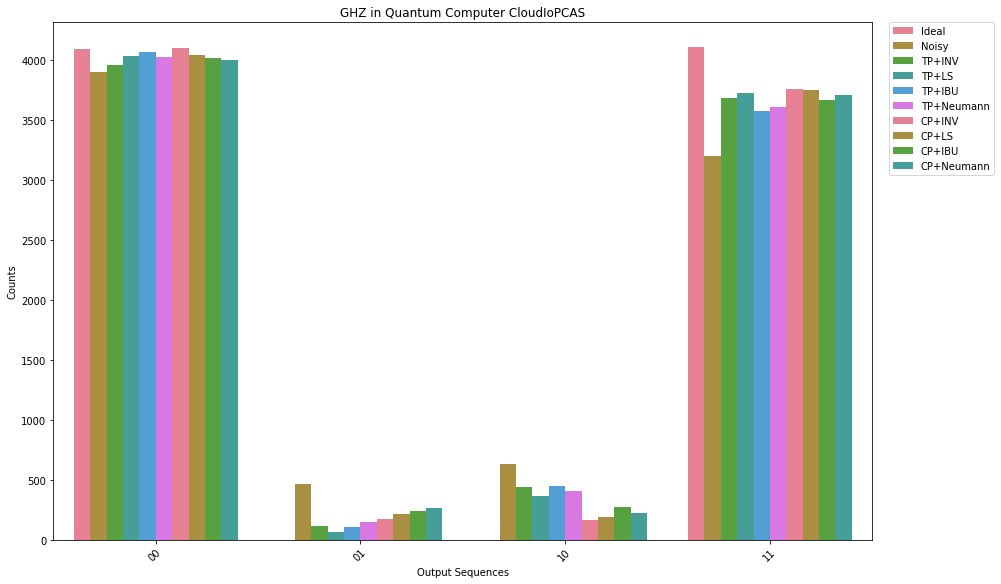

In [15]:
# Visualize the ideal, noisy, and mitigated counts
counts_list = [dict2vector(counts_ideal),
               dict2vector(counts_noisy),
               dict2vector(counts_tp_inv), dict2vector(counts_tp_ls), dict2vector(counts_tp_ibu), dict2vector(counts_tp_neu),
               dict2vector(counts_cp_inv), dict2vector(counts_cp_ls), dict2vector(counts_cp_ibu), dict2vector(counts_cp_neu)]
legends = ['Ideal', 'Noisy', 'TP+INV', 'TP+LS', 'TP+IBU', 'TP+Neumann', 'CP+INV', 'CP+LS', 'CP+IBU', 'CP+Neumann']

plot_histograms(counts_list, legends,
                title="GHZ in Quantum Computer {}".format(noisy_qc_name),
                fig_name="GHZ_Counts_MEM_{}_N{}.png".format(noisy_qc_name, n))



Then for the expectation value. It can be noted that there are observable improvements for these eight cases.

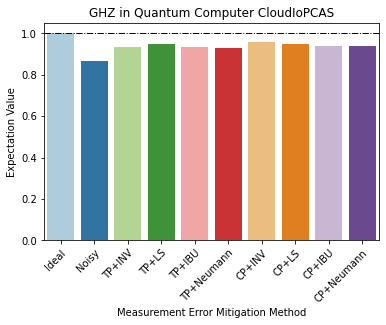

In [16]:
# Visualize the ideal, noisy, and mitigated expectation values
plt.figure()
ax = plt.gca()

expval_list = [val_ideal, val_noisy, val_tp_inv, val_tp_ls, val_tp_ibu, val_tp_neu, val_cp_inv, val_cp_ls, val_cp_ibu, val_cp_neu]
expval_array = np.zeros((len(expval_list), 2))
for i, val in enumerate(expval_list):
    expval_array[i][0] = i
    expval_array[i][1] = val

df = pandas.DataFrame(expval_array, columns=["Measurement Error Mitigation Method", "Expectation Value"])
seaborn.barplot(x=df['Measurement Error Mitigation Method'],
                y=df['Expectation Value'],
                palette=seaborn.color_palette("Paired"))

# Add the theoretical reference line
plt.axhline(y=1, color='black', linestyle='-.', linewidth=1, zorder=1)

ax.set_xticklabels(legends)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("GHZ in Quantum Computer {}".format(noisy_qc_name), fontsize=12)
# plt.tight_layout()

plt.savefig("GHZ_ExpVal_MEM_{}_N{}.png".format(noisy_qc_name, n),
            format='png',
            dpi=600,
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

## Summary
Through a simple example of GHZ state, we can see how calibration and correction are applied to the calculation process, what roles they play, and how they cooperate with each other to correct the statistical results containing measurement noise.

According to the results of different combinations of these eight calibrations and corrections, we can see that the results are very good. Theoretically, compared with tensor product calibration, the correction results based on complete model calibration are generally closer to the true value, because complete model calibration obtains all the statistical information of measurement noise at the cost of resources. In practical application, We need to make a trade-off between the two calibration methods, because we can also see that the correction results based on tensor product calibration also have quite good accuracy, which is a cost-effective model.

## References

[1] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." [Nature Communications](https://www.nature.com/articles/ncomms5213), 5.1 (2014): 1-7.

[2] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." [arXiv](https://arxiv.org/abs/1411.4028) preprint arXiv:1411.4028, 2014.

[3] Biamonte, Jacob, et al. "Quantum machine learning." [Nature](https://www.nature.com/articles/nature23474) 549.7671 (2017): 195-202.

[4] Havlíček, Vojtěch, et al. "Supervised learning with quantum-enhanced feature spaces." [Nature](https://www.nature.com/articles/s41586-019-0980-2), 567.7747 (2019): 209-212.

[5] Chow, Jerry M., et al. "Universal quantum gate set approaching fault-tolerant thresholds with superconducting qubits." [Physical Review Letters](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.060501) 109.6 (2012): 060501.

[6] Kandala, Abhinav, et al. "Error mitigation extends the computational reach of a noisy quantum processor." [Nature](https://www.nature.com/articles/s41586-019-1040-7), 567.7749 (2019): 491-495.

[7] Michael R Geller. "Rigorous measurement error correction." [Quantum Science and Technology](https://iopscience.iop.org/article/10.1088/2058-9565/ab9591), 5(3):03LT01, 2020.

[8] Wikipedia contributors. "Computational complexity of mathematical operations." [Wikipedia](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations), 2021. 

[9] Wikipedia contributors. "Moore–Penrose inverse." [Wikipedia](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse), 2021.

[10] Wikipedia contributors. "Bayes' theorem." [Wikipedia](https://en.wikipedia.org/wiki/Bayes%27_theorem), 2021.

[11] Nachman, Benjamin, et al. "Unfolding quantum computer readout noise." [npj Quantum Information](https://arxiv.org/abs/1910.01969) 6.1 (2020): 1-7.

[12] Wang, Kun, Yu-Ao Chen, and Xin Wang. "Measurement Error Mitigation via Truncated Neumann Series." [arXiv](https://arxiv.org/abs/2103.13856) preprint arXiv:2103.13856, 2021.